In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering

In [3]:
# read the data to python env
data=pd.read_csv('/content/drive/MyDrive/datasets/Wholesale_customers data.csv')

In [4]:
# copy the dataset to another variable df
df=data.copy()

#1.Data Familiarisation

In [5]:
# first 3 rows of the dataset
df.head(3)

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844


In [6]:
# last 3 rows of the dataset
df.tail(3)

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
437,2,3,14531,15488,30243,437,14841,1867
438,1,3,10290,1981,2232,1038,168,2125
439,1,3,2787,1698,2510,65,477,52


So our data got different wholesale product & sale details.

In [7]:
# info about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


Note:
1. There is no missing values in the dataset
2. All are numerical columns-int type
3. 440 obserations are there in the provided dataset

In [8]:
# shape of the data
df.shape

(440, 8)

our dataset contains 440 rows and 8 columns

In [9]:
# print the statistic summary of the dataset
df.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


Note: There are some outliers in the dataset

In [10]:
# check for the duplicated rows
df[df.duplicated()]

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen


No duplicate rows in the dataset.

#2. Pre Processing

In [11]:
# check for null values
df.isna().sum()

Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

No null values present in the dataset.

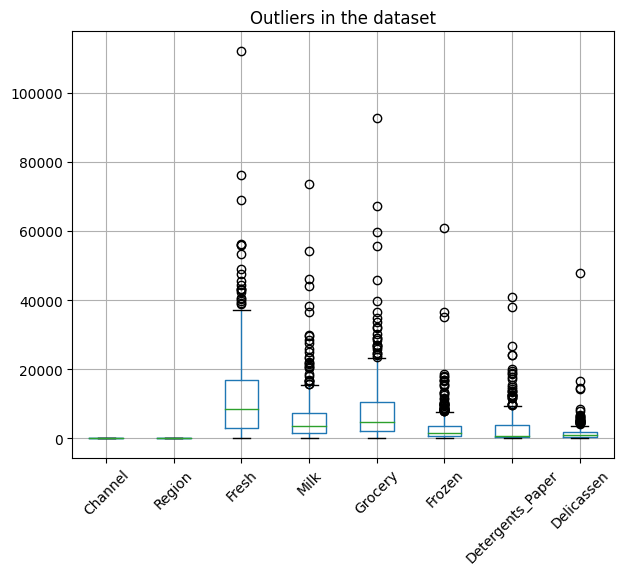

In [12]:
# check for outliers
df.boxplot()
plt.tight_layout()
plt.xticks(rotation=45)
plt.title("Outliers in the dataset")
plt.show()

There are some outliers in the dataset. Handling the outliers using inter quartile range method.

In [13]:
# Handling of outliers
out_cols=['Fresh', 'Milk', 'Grocery', 'Frozen',
       'Detergents_Paper', 'Delicassen']

# calculate upper & lower limit for each column using IQR
for col in out_cols:
  Q1=df[col].quantile(0.25)
  Q3=df[col].quantile(0.75)

  IQR= Q3-Q1

  upper=Q3 + (1.5*IQR)
  lower=Q1 -(1.5*IQR)

  # replacing outlier with the cut off values
  df[col]=np.where(df[col]<lower,lower,np.where(df[col]>upper,upper,df[col]))

Now, outliers has been removed from the dataset.

# 3. Dimentianality Reduction

In [14]:
# columns in the dataset
df.columns

Index(['Channel', 'Region', 'Fresh', 'Milk', 'Grocery', 'Frozen',
       'Detergents_Paper', 'Delicassen'],
      dtype='object')

In [15]:
# values of Region column
df['Region'].value_counts()

Region
3    316
1     77
2     47
Name: count, dtype: int64

In [16]:
# unique values of channel column
df['Channel'].value_counts()

Channel
1    298
2    142
Name: count, dtype: int64

Note: There is no redundant columns to drop, will apply PCA for dimentionality reduction

In [17]:
# import libraries
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA

In [18]:
# scale the df
x=pd.DataFrame(scale(df),index=data.index,columns=data.columns)
# create an object of PCA
# need 3 PCA components
pc=PCA(n_components=3)
# fit_transform the x values
pc_array=pc.fit_transform(x)

In [19]:
# create a new dtaframe with PCA components
PC_df=pd.DataFrame(pc_array,columns=['PC1','PC2','PC3'])

#4. Apply Different clustering methods

## a. KMeans Clustering

In [20]:
# Find the optimal values of clusters
# will use elbow method to calculate optimum no of clusters
# will plot the WCSS value for a range of K, then find the optimum cluster

x=PC_df.copy()
# empty list to store WCSS (within cluster sum of square)value
WCSS=[]
kmeans=KMeans(n_clusters=range(1,11),init="k-means++",n_init=10)

for i in range(1,11):
  kmeans=KMeans(n_clusters=i,init="k-means++",n_init=10)
  # fit the data
  kmeans.fit(PC_df)
  # calulate WCSS value & append to the list
  WCSS.append(kmeans.inertia_)


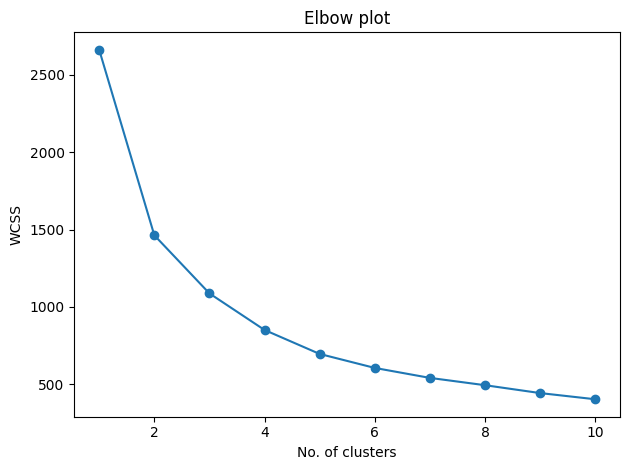

In [21]:
# elbow plot
plt.plot(range(1,11),WCSS,'-o')
plt.title("Elbow plot")
plt.xlabel("No. of clusters")
plt.ylabel("WCSS")
plt.tight_layout()
plt.show()

Note: Optimum no of cluster is 4.  we can see that the graph will rapidly change at a point 4 and thus creating an elbow shape. From this point, the graph moves almost parallel to the X-axis.

In [56]:
# create the model with the optimum number of clusters
kmeans=KMeans(n_clusters=4,init="k-means++",n_init=10)
# fit the data
kmeans.fit(x)
kmean_label=kmeans.predict(x)
kmean_label

array([1, 1, 1, 3, 3, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 3, 1, 0, 0, 0,
       3, 1, 1, 0, 0, 0, 1, 0, 3, 0, 0, 3, 0, 1, 3, 1, 1, 3, 3, 3, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 3, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1,
       0, 1, 3, 0, 3, 3, 0, 3, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 3,
       0, 3, 0, 3, 1, 3, 1, 0, 0, 0, 0, 0, 1, 1, 1, 3, 0, 0, 1, 1, 1, 1,
       0, 1, 3, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 1, 3, 3, 3, 1, 0, 3, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       3, 3, 0, 0, 0, 3, 1, 3, 0, 0, 0, 0, 1, 1, 3, 0, 0, 1, 0, 3, 3, 1,
       2, 2, 1, 1, 3, 2, 2, 1, 2, 2, 2, 1, 2, 1, 2, 2, 1, 1, 1, 2, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2,
       2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 3, 2, 2, 2, 3, 2, 2, 2, 2, 2,
       1, 3, 1, 3, 1, 2, 2, 2, 2, 3, 0, 0, 3, 0, 3, 1, 0, 1, 3, 3, 3, 0,
       0, 3, 0, 0, 0, 0, 0, 1, 2, 0, 2, 0, 1, 0, 1,

In [57]:
# calculate silhouette_score for Kmeans
kmean_score=silhouette_score(x,kmean_label,random_state=42)
print(kmean_score)

0.4038910837851478


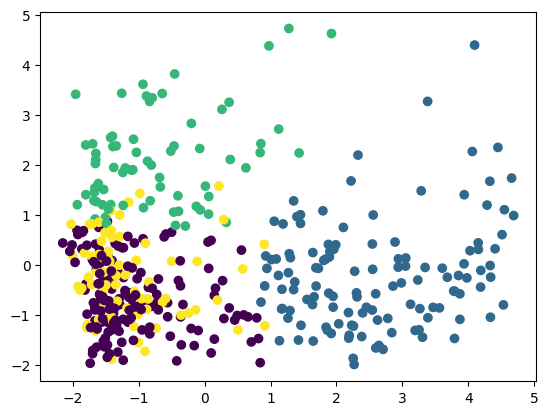

In [39]:
# Visualise the clusters
plt.scatter(x['PC1'],x['PC2'],c=kmean_label)

Note: There are some overlap between the clusters. Optimum no of cluster based on K-Menas clustering is 4

# b. Agglomerative clustering

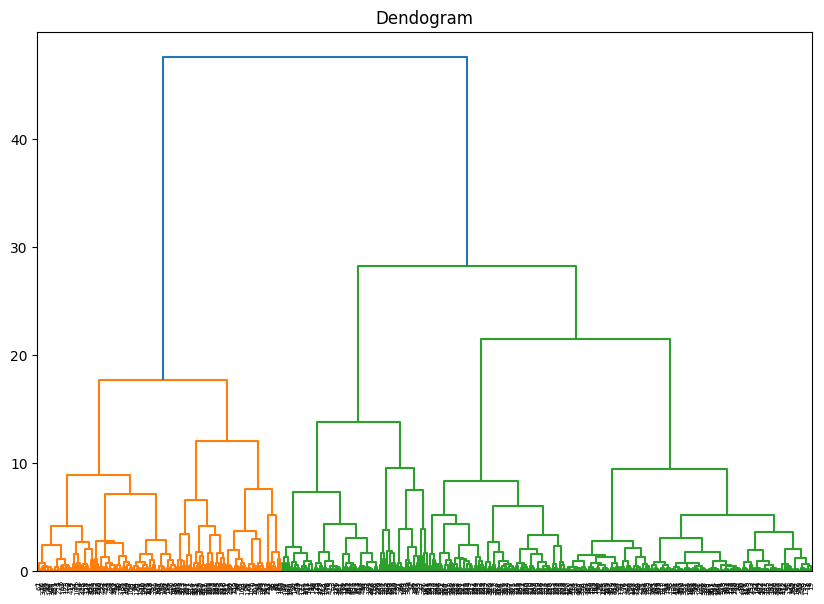

In [24]:
# find the optimum value of cluster using dendogram
# calculate linkage value
mergings=linkage(x,method='ward',metric='euclidean')
plt.figure(figsize=(10,7))
# plot teh dendogram
dendrogram(mergings)
plt.title('Dendogram')
plt.show()

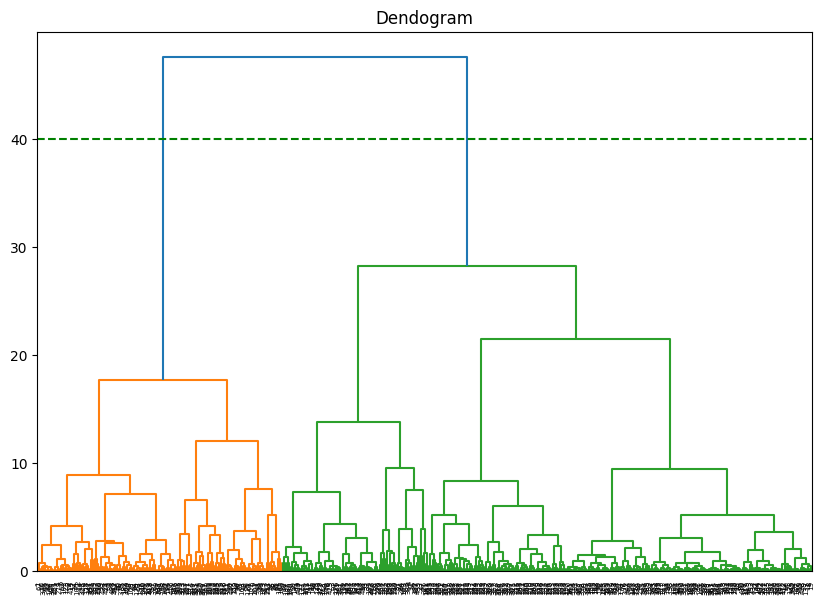

In [25]:
# lets draw the horizontal line crossing the max vertical/euclidean distance
mergings=linkage(x,method='ward',metric='euclidean')
plt.figure(figsize=(10,7))
# plot the dendogram
dendrogram(mergings)
plt.axhline(y=40,color='green',linestyle='--')
plt.title('Dendogram')
plt.show()

from the graph, we can see that No. of optimum cluster is 2.

In [26]:
# create the model with the optimum number of clusters
ag=AgglomerativeClustering(n_clusters=2,affinity='euclidean',linkage='ward')
y_hc=ag.fit_predict(x)
y_hc

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


array([1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1,

In [27]:
# calculate silhouette_score for HC
HC_score=silhouette_score(x,y_hc,random_state=42)
print(HC_score)

0.42443982991378343


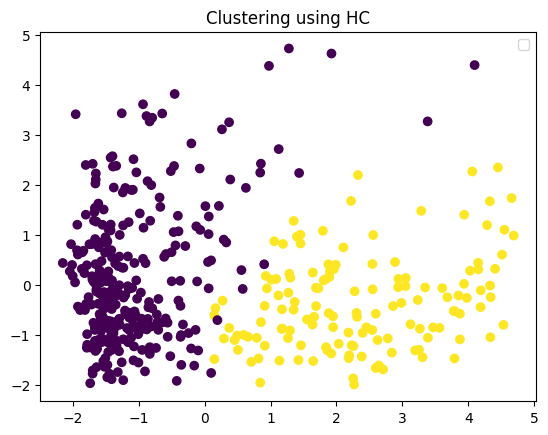

In [43]:
# visulaise the graph
plt.scatter(x['PC1'],x['PC2'],c=y_hc)
plt.title('Clustering using HC')
plt.legend()
plt.show()

Note: clusters are well apart compared to Kmeans, Optimum no of cluster based on Agglomerative HC is 2.

## c. DBScan CLustering

In [28]:
from sklearn.cluster import DBSCAN

In [ ]:
# eps: use k-distance graph to find the eps
# MinPts: The larger the dataset, the larger value of MinPts must be chosen. As a general rule, the minimum MinPts can be derived from the number of dimensions D in the dataset as, MinPts >= D+1. The minimum value of MinPts must be chosen at least 3.
# In this algorithm, we have 3 types of data points.
#Core Point: A point is a core point if it has more than MinPts points within eps.
#Border Point: A point which has fewer than MinPts within eps but it is in the neighborhood of a core point.
#Noise or outlier: A point which is not a core point or border point.

# Steps Used In DBSCAN Algorithm
# Find all the neighbor points within eps and identify the core points or visited with more than MinPts neighbors.
# For each core point if it is not already assigned to a cluster, create a new cluster.
# Find recursively all its density-connected points and assign them to the same cluster as the core point.
# Iterate through the remaining unvisited points in the dataset. Those points that do not belong to any cluster are noise.

In [29]:
# find the optimal eps and min_samples values for DBSCAN using k-distance graph and the silhouette score.
from sklearn.neighbors import NearestNeighbors

knn = NearestNeighbors(n_neighbors=7)
knn.fit(x)
distances, _ = knn.kneighbors()

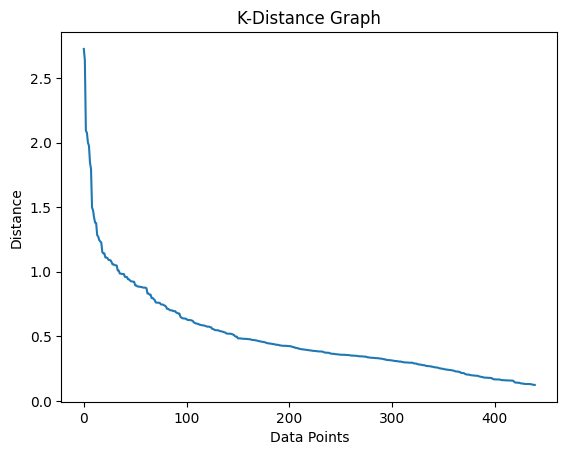

In [30]:
# Sort the distances and plot the distance graph
distances = sorted(distances[:, 3], reverse=True)
plt.plot(range(len(distances)), distances)
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.title('K-Distance Graph')
plt.show()

Note: eps value, is a point in the K-distnace graph, where it has the max bend. in this case we can go for value of 0.8.

In [31]:
from itertools import product

In [33]:
# calculate silhouette_score for a set of eps_values & min_samples

eps_values = np.arange(0.6, 0.9, 0.1)  # Generate values from 0.6 to 0.8 with a step size of 0.1
min_samples = np.arange(3, 10)# sample values

DBSCAN_params = list(product(eps_values, min_samples)) # combinations of both

result = []


for p in DBSCAN_params:
    # fit the data & calculate score
    DBS_clustering = DBSCAN(eps=p[0], min_samples=p[1]).fit(x)
    result_dict = {
        'Epsilon': p[0],
        'Min Samples': p[1],
        'Clusters': len(np.unique(DBS_clustering.labels_)),
        'Silhouette Score': silhouette_score(x, DBS_clustering.labels_)
    }
    # append the value to the list,result
    result.append(result_dict)

In [34]:
# create DF
dbscan_df=pd.DataFrame(result)
dbscan_df

,Epsilon,Min Samples,Clusters,Silhouette Score
0,0.6,3,7,-0.153939
1,0.6,4,4,0.100297
2,0.6,5,6,-0.028166
3,0.6,6,4,0.007464
4,0.6,7,3,0.166852
5,0.6,8,4,0.108358
6,0.6,9,5,0.109932
7,0.7,3,9,-0.128546
8,0.7,4,6,-0.006369
9,0.7,5,4,0.103468


In [35]:
# filter dbscan_df for high poistive score
dbscan_df.loc[dbscan_df['Silhouette Score'].idxmax()]

Epsilon             0.900000
Min Samples         9.000000
Clusters            2.000000
Silhouette Score    0.305582
Name: 27, dtype: float64

Note:
1. Optimum value of cluster is 2 as per dbscan algorithm for Epsilon of 0.9 and Min sample=9

In [45]:
# model with optimum no of clusters
# labels from the algorithm
DBS_clustering = DBSCAN(eps=0.9, min_samples=9).fit(x)
labels_db=DBS_clustering.labels_
labels_db

array([ 0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0, -1, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0, -1, -1,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,
        0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0, -1,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0, -1,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1,  0,  0, -1, -1, -1,  0,
        0, -1,  0, -1,  0, -1,  0, -1,  0,  0, -1, -1, -1,  0, -1,  0,  0,
        0,  0, -1,  0,  0

In [46]:
silhouette_score(x, DBS_clustering.labels_)

0.30558156966253125

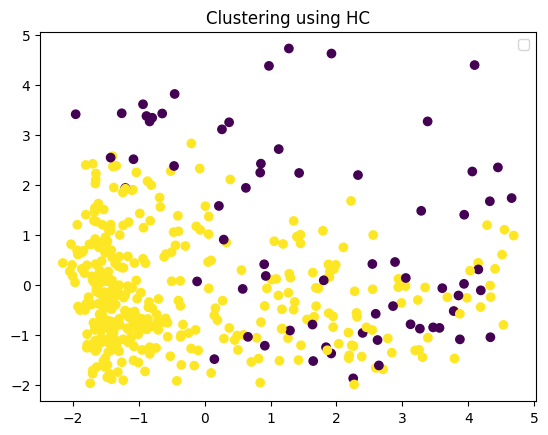

In [47]:
# visulaise the graph
plt.scatter(x['PC1'],x['PC2'],c=labels_db)
plt.title('Clustering using HC')
plt.legend()
plt.show()

Note: Clusters are overlapped to each other compared to other 2 models. Optimum no fo cluster based on DBscan algorithm is 2.